In [1]:
import pandas as pd
import json 
import matplotlib.pyplot as plt

df = pd.read_json('transaction-data-adhoc-analysis.json')

In [2]:
df

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24
...,...,...,...,...,...,...,...,...,...
83031,"96081 Harrison Brooks\nJenniferbury, MA 02124",2019/10/26,christina55@hotmail.com,Tammy Byrd,F,kmcconnell,"Exotic Extras,Kimchi and Seaweed,(x2);HealthyK...",3588,2022/06/05
83032,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,"HealthyKid 3+,Yummy Vegetables,(x1);Exotic Ext...",2095,2022/06/12
83033,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,"Candy City,Orange Beans,(x4);Candy City,Gummy ...",3396,2022/06/15
83034,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,"HealthyKid 3+,Nutrional Milk,(x2);Candy City,G...",4280,2022/06/09


In [3]:
#transaction individual items computed manually:

price_list = {
'HealthyKid 3+,Gummy Vitamins' : 1500,
'Candy City,Gummy Worms' : 150,
'Exotic Extras,Beef Chicharon' : 1299,
'Candy City,Orange Beans' : 199,
'HealthyKid 3+,Nutrional Milk' : 1990,
'Exotic Extras,Kimchi and Seaweed' : 799,
'HealthyKid 3+,Yummy Vegetables' : 500,
}
 

### Transforming the data into a granularity of one “line item” per row, adding transaction_id and quantity columns for easier data manipulation


In [4]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_id'] = df.index
#make the items into a list and clean the data                                                     
df['transaction_items'] = df['transaction_items'].apply(lambda x: x.split(';'))

#this splits the items into individual rows
df = df.explode('transaction_items')

def quantity_col(row):
    #if last char in string is ')' then the item has a quantity not 1
    if row['transaction_items'][-1] == ")":
        return row['transaction_items'][-2]
    else:
        return 1

df['quantity'] = df.apply(lambda row: quantity_col(row), axis=1)

def clean_transaction_items(row):
    #remove ('x'n) in transaction_items
    if row['transaction_items'][-1] == ")":
        return row['transaction_items'][:-5]
    else:
        return row['transaction_items']

df['transaction_items'] = df.apply(lambda row: clean_transaction_items(row), axis=1)

def update_transaction_value(row):
    #value = item_price * quantity
    return price_list[row['transaction_items']] * int(row['quantity'])

df['transaction_value'] = df.apply(lambda row: update_transaction_value(row), axis=1)

In [5]:
print("Start of Date Range: {}".format(df['transaction_date'].min()))
print("End of Date Range: {}".format(df['transaction_date'].max()))

Start of Date Range: 2022-01-01 00:00:00
End of Date Range: 2022-06-30 00:00:00


Date Range: 2022-01-01 - 2022-01-31

Total Sold Count: 68041
Total Sale Value: 62522565
                                  sold_count  price  sale_value
item                                                           
Candy City,Gummy Worms                  9559    150     1433850
Candy City,Orange Beans                 9774    199     1945026
Exotic Extras,Beef Chicharon            9665   1299    12554835
Exotic Extras,Kimchi and Seaweed        9676    799     7731124
HealthyKid 3+,Gummy Vitamins            9681   1500    14521500
HealthyKid 3+,Nutrional Milk            9727   1990    19356730
HealthyKid 3+,Yummy Vegetables          9959    500     4979500


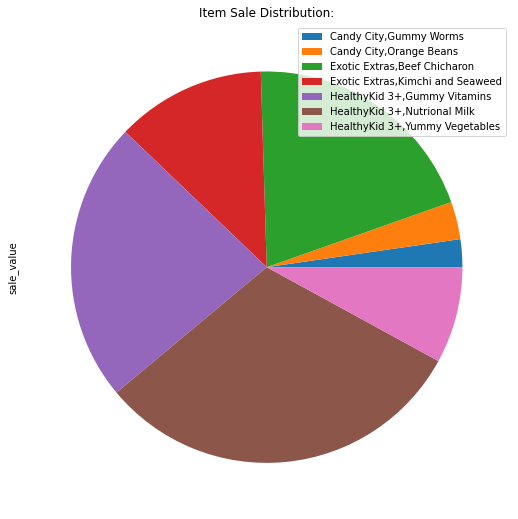

In [86]:
def breakdown_by_month(start, end):
    #start, end date inclusive
    
    filtered = df.loc[(df['transaction_date'] >= pd.to_datetime(start)) & (df['transaction_date'] <= pd.to_datetime(end))]

    def breakdown(dataframe):
        #count
        item_counter = {}
        for index, row in dataframe.iterrows():
            item = row['transaction_items']
            if item not in item_counter:
                item_counter[item] = 0
            item_counter[item] += int(row['quantity'])

        item_sales = pd.DataFrame(item_counter.items(), columns=['item', 'sold_count',])
        item_sales = item_sales.sort_values(by='item')

        def price_col(row):
            return price_list[row['item']]

        def value_col(row):
            return row['sold_count'] * price_list[row['item']]

        item_sales['price'] = item_sales.apply(lambda row: price_col(row), axis=1)
        item_sales['sale_value'] = item_sales.apply(lambda row: value_col(row), axis=1)
        item_sales = item_sales.reset_index(drop=True)
        item_sales = item_sales.set_index('item')
        
        print("Total Sold Count: {}".format(item_sales['sold_count'].sum()))
        print("Total Sale Value: {}".format(item_sales['sale_value'].sum()))
        
#         ax = item_sales.plot.barh(x='item', y='sale_value', figsize=(16,9))
#         ax
        item_sales.plot.pie(y='sale_value', figsize=(16,9), labels=None, fontsize=10, title='Item Sale Distribution:')
    
        return item_sales
    
    print("Date Range: {} - {}".format(start, end))
    print()
    print(breakdown(filtered))
    return 



breakdown_by_month('2022-01-01', '2022-01-31')


Date Range: 2022-02-01 - 2022-02-28

Total Sold Count: 69910
Total Sale Value: 63820403
                                  sold_count  price  sale_value
item                                                           
Candy City,Gummy Worms                  9996    150     1499400
Candy City,Orange Beans                10037    199     1997363
Exotic Extras,Beef Chicharon           10001   1299    12991299
Exotic Extras,Kimchi and Seaweed        9949    799     7949251
HealthyKid 3+,Gummy Vitamins            9980   1500    14970000
HealthyKid 3+,Nutrional Milk            9691   1990    19285090
HealthyKid 3+,Yummy Vegetables         10256    500     5128000


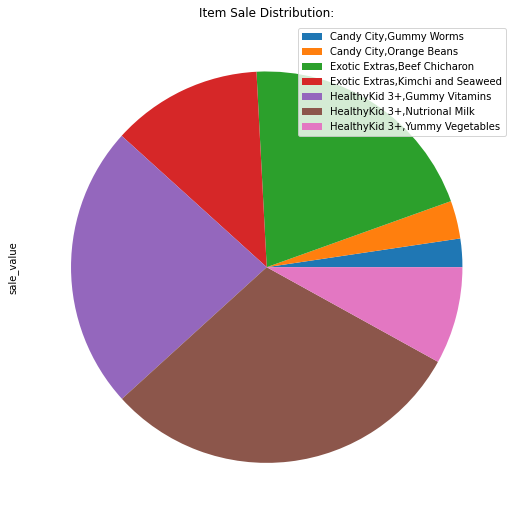

In [87]:
breakdown_by_month('2022-02-01', '2022-02-28')

In [7]:
def get_month_table(start, end):
    filtered = df.loc[(df['transaction_date'] >= pd.to_datetime(start)) & (df['transaction_date'] <= pd.to_datetime(end))]
    filtered = filtered.sort_values(by=['transaction_date', 'transaction_id'])
    return filtered

January2022 = get_month_table('2022-01-01', '2022-01-31')
February2022 = get_month_table('2022-02-01', '2022-02-28')
March2022 = get_month_table('2022-03-01', '2022-03-31')
April2022 = get_month_table('2022-04-01', '2022-04-30')
May2022 = get_month_table('2022-05-01', '2022-05-31')
June2022 = get_month_table('2022-06-01', '2022-06-30')

months = [0, January2022, February2022, March2022, April2022, May2022, June2022]

In [8]:
def top_users(month_num=None):
    if month_num is None:
        table = df
    else:
        table = months[month_num]
    table['name'].apply(lambda x: x.upper())
    names_list = {}
    transaction_ids = []
    for index, row in table.iterrows():
        name = row['name']
        if name not in names_list:
            names_list[name] = {'unique_transactions' :0, 'total_items_bought_count' :0, 'total_items_bought_value': 0, 
                                'latest_transaction':0,}
        if row['transaction_id'] not in transaction_ids:
            transaction_ids.append(row['transaction_id'])
            names_list[name]['unique_transactions'] += 1
        names_list[name]['total_items_bought_count'] += int(row['quantity'])
        names_list[name]['total_items_bought_value'] += int(row['transaction_value'])
        names_list[name]['latest_transaction'] = row['transaction_date']
    

    names, unique, count, value, latest = [],[],[],[],[]
    for k, v in names_list.items():
        names.append(k)
        unique.append(v['unique_transactions'])
        count.append(v['total_items_bought_count'])
        value.append(v['total_items_bought_value'])
        latest.append(v['latest_transaction'])
        
    data = pd.DataFrame(list(zip(names, unique, count, value, latest)), columns= ['name', 'unique_transactions', 'total_items_bought_count',
                                                                                 'total_items_bought_value', 'latest_transaction'])
    return data.sort_values(by='total_items_bought_value', ascending=False)

### Top Users from Jan to June


In [99]:
top_users()

,name,unique_transactions,total_items_bought_count,total_items_bought_value,latest_transaction
420,Michael Johnson,60,292,286846,2022-06-23
455,David Smith,66,282,280116,2022-06-17
1004,Christopher Smith,47,271,274437,2022-06-10
2184,Michael Green,48,238,230030,2022-06-13
196,Christopher Johnson,54,258,218707,2022-06-26
...,...,...,...,...,...
8444,Margaret Perez,1,2,2098,2022-04-12
3743,Donald Hoffman,3,9,1896,2022-03-10
8377,Jacqueline Lee,2,7,1295,2022-05-20
8423,Travis Wiggins,1,4,999,2022-04-29


### Top users Jan only

,name,unique_transactions,total_items_bought_count,total_items_bought_value,latest_transaction
2749,Michael Green,10,54,64308,2022-01-30
2490,Michael Williams,8,53,57031,2022-01-23
691,Jeffrey Williams,11,43,50410,2022-01-25
4024,Robert Anderson,8,43,48591,2022-01-26
843,Jason Sanchez,6,42,46251,2022-01-18
...,...,...,...,...,...
4165,Robert Mann,1,1,150,2022-01-13
148,Felicia Herman,1,1,150,2022-01-01
4295,April Sanchez,1,1,150,2022-01-14
4332,Leslie Campbell,1,1,150,2022-01-14


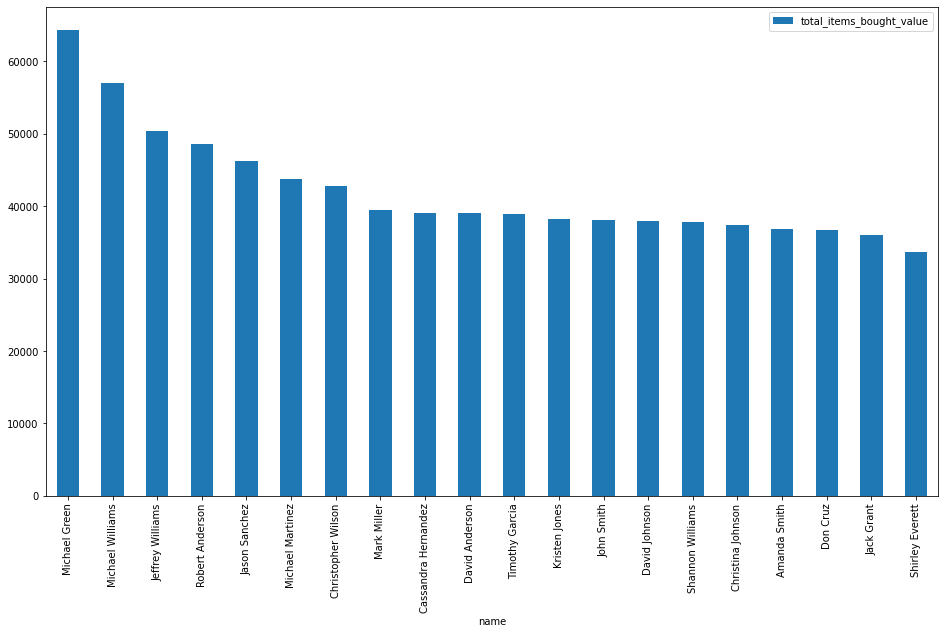

In [27]:
january_top_users = top_users(1)
january_top_users.head(20).plot.bar(x='name', y='total_items_bought_value', figsize=(16,9))
january_top_users

In [59]:
def repeat_users(month_num):
    if month_num > 1:
        previous_month_names = months[month_num - 1]['name'].unique()
        current_month_names = months[month_num]['name'].unique()

        repeat_count = 0
        for name in current_month_names:
            if name in previous_month_names:
                repeat_count += 1
        output = ("Repeat users(purchased previous and current month): {}".format(repeat_count))
        return output
    else:
        return 0 


print("Jan: {}".format(repeat_users(1)))
print("Feb: {}".format(repeat_users(2)))
print("Mar: {}".format(repeat_users(3)))
print("Apr: {}".format(repeat_users(4)))
print("May: {}".format(repeat_users(5)))
print("June: {}".format(repeat_users(6)))


Jan: 0
Feb: Repeat users(purchased previous and current month): 5172
Mar: Repeat users(purchased previous and current month): 5216
Apr: Repeat users(purchased previous and current month): 5154
May: Repeat users(purchased previous and current month): 5110
June: Repeat users(purchased previous and current month): 5193


In [61]:
def inactive_users(month_num):
    if month_num > 1:
        previous_month_names = months[month_num - 1]['name'].unique()
        current_month_names = months[month_num]['name'].unique()
        repeat_count = 0
        for name in previous_month_names:
            if name in current_month_names:
                repeat_count += 1
        output = ("Inactive users(purchased previous but not current month): {}".format(repeat_count))
    else:
        return 0
    
print("Jan: {}".format(inactive_users(1)))
print("Feb: {}".format(inactive_users(2)))
print("Mar: {}".format(inactive_users(3)))
print("Apr: {}".format(inactive_users(4)))
print("May: {}".format(inactive_users(5)))
print("June: {}".format(inactive_users(6)))

Jan: 0
Feb: None
Mar: None
Apr: None
May: None
June: None


In [88]:
def engaged_users():
    jan_users = months[1]['name'].unique()
    feb_users = months[2]['name'].unique()
    mar_users = months[3]['name'].unique()
    apr_users = months[4]['name'].unique()
    may_users = months[5]['name'].unique()
    jun_users = months[6]['name'].unique()
    
    engaged_list = []
    
    for name in jan_users:
        if name in feb_users and name in mar_users and name in apr_users and name in may_users and name in jun_users:
            engaged_list.append(name)
            
    print(len(engaged_list))
    return engaged_list

engaged_users_list = engaged_users()

2190


In [97]:
def top_engaged_users():
    table = df[df['name'].isin(engaged_users_list)]
    names_list = {}
    transaction_ids = []
    for index, row in table.iterrows():
        name = row['name']
        if name not in names_list:
            names_list[name] = {'unique_transactions' :0, 'total_items_bought_count' :0, 'total_items_bought_value': 0, 
                                'latest_transaction':0,}
        if row['transaction_id'] not in transaction_ids:
            transaction_ids.append(row['transaction_id'])
            names_list[name]['unique_transactions'] += 1
        names_list[name]['total_items_bought_count'] += int(row['quantity'])
        names_list[name]['total_items_bought_value'] += int(row['transaction_value'])
        names_list[name]['latest_transaction'] = row['transaction_date']
    

    names, unique, count, value, latest = [],[],[],[],[]
    for k, v in names_list.items():
        names.append(k)
        unique.append(v['unique_transactions'])
        count.append(v['total_items_bought_count'])
        value.append(v['total_items_bought_value'])
        latest.append(v['latest_transaction'])
        
    data = pd.DataFrame(list(zip(names, unique, count, value, latest)), columns= ['name', 'unique_transactions', 'total_items_bought_count',
                                                                                 'total_items_bought_value', 'latest_transaction'])
    return data.sort_values(by='total_items_bought_value', ascending=False)

top_engaged_users().head(20)

,name,unique_transactions,total_items_bought_count,total_items_bought_value,latest_transaction
151,Michael Johnson,60,292,286846,2022-06-23
160,David Smith,66,282,280116,2022-06-17
345,Christopher Smith,47,271,274437,2022-06-10
764,Michael Green,48,238,230030,2022-06-13
71,Christopher Johnson,54,258,218707,2022-06-26
1340,John Smith,39,225,206619,2022-06-03
1138,Jeffrey Williams,43,218,205213,2022-06-05
1404,Victoria Smith,38,206,203688,2022-06-19
463,Benjamin Clark,38,211,196960,2022-06-02
42,Michael Smith,35,194,193893,2022-06-13
